In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

#for replicability purposes
tf.random.set_seed(91195003)
#for an easy reset backend session state
tf.keras.backend.clear_session()

In [2]:

#Load dataset
def load_dataset(path=r'yahoo_stock.csv'):
  return pd.read_csv(path)

In [3]:
#split data into training and validation sets
def split_data(training, perc=10):
  train_idx = np.arange(0, int(len(training)*(100-perc)/100))
  val_idx = np.arange(int(len(training)*(100-perc)/100+1), len(training))
  return train_idx, val_idx

In [4]:
def prepare_data(df):
  df_aux = df.drop(columns=['High', 'Low', 'Volume', 'Adj Close'], inplace=False)
  df_aux = df_aux.set_index('Date')
  return df_aux

In [5]:
def data_normalization(df, norm_range=(-1, 1)):
  #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
  scaler = MinMaxScaler(feature_range=norm_range)
  df[['Open']] = scaler.fit_transform(df[['Open']])
  df[['Close']] = scaler.fit_transform(df[['Close']])
  return scaler

In [6]:
#plot learning curve
def plot_learning_curves(history, epochs):
  #accuracies and losses
  #dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse'])
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  epochs_range = range(epochs)
  #creating figure
  plt.figure(figsize=(8,8))
  plt.subplot(1,2,2)
  plt.plot(epochs_range,loss,label='Training Loss')
  plt.plot(epochs_range,val_loss,label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training/Validation Loss')
  plt.show()

In [7]:
#Plot time series data
def plot_confirmed_cases(data):
  plt.figure(figsize=(8,6))
  plt.plot(range(len(data)), data)
  plt.title('Confirmed Cases of COVID-19')
  plt.ylabel('Cases')
  plt.xlabel('Days')
  plt.show()

In [8]:
#Preparing the dataset for the LSTM
def to_supervised(df, timesteps):
  data = df.values
  X, y = list(), list()
  #iterate over the training set to create X and y
  dataset_size = len(data)
  for curr_pos in range(dataset_size):
    #end of the input sequence is the current position + the number of timesteps of the input sequence
    input_index = curr_pos + timesteps
    #end of the labels corresponds to the end of the input sequence + 1
    label_index = input_index + 1
    #if we have enough data for this sequence
    if label_index < dataset_size:
      X.append(data[curr_pos:input_index, :])
      y.append(data[input_index:label_index, 0])
  #using np.float32 for GPU performance
  return np.array(X).astype('float32'), np.array(y).astype('float32')

In [9]:
#Building the model
def rmse(y_true, y_pred):
  return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))


In [10]:
def build_model(timesteps, features, h_neurons=64, activation='tanh'):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(h_neurons, activation=activation, input_shape=(timesteps, features), return_sequences=True))
  #Add a new layer
  model.add(tf.keras.layers.LSTM(32, activation=activation ,return_sequences=False))
  #
  model.add(tf.keras.layers.Dense(h_neurons, activation=activation))
  model.add(tf.keras.layers.Dense(n_variate, activation='linear'))
  #model summary (and save it as PNG)
  tf.keras.utils.plot_model(model, 'yahoo_model.png', show_shapes=True)
  return model

In [11]:
#Compiling and fit the model
def compile_and_fit(model, epochs, batch_size):
  #compile
  model.compile(loss = rmse, optimizer = tf.keras.optimizers.Adam(), metrics = ['mae', rmse])
  #fit
  hist_list = list()
  loss_list = list()

  #callback
  #saving in Keras HDF5 (or h5), a binary data format
  callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath='my_model_{epoch}_{val_loss:.3f}.h5',#path where to save model
        save_best_only=True,#overwrite the current checkpoint if and only if
        monitor='val_loss',#the val_loss score has improved
        save_weights_only=False,#if True, only the weigths are saved
        verbose=1,#verbosity mode
        period=5 #save ony at the fifth epoch (5 em 5 epocas) 
        )#,
    #interrupt training if loss stops improving for over 2 epochs
    #tf.keras.callbacks.EarlyStopping(patience=9, monitor='cost')
    ]

  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=cv_splits)
  for train_index, test_index in tscv.split(X):
    train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets
    #build data
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_index], y[test_index]

    #print("x_val::::",X_val,"\n","y_val:",y_val,"\n")

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, shuffle=False, callbacks=callbacks)
    metrics = model.evaluate(X_test, y_test)


    plot_learning_curves(history, epochs)
    hist_list.append(history)


  return model, hist_list

In [12]:
#Main Execution
#the dataframes
df_raw = load_dataset()
#Get data from 2015 to the end of 2018
df_raw = df_raw[:1134]
df_data = prepare_data(df_raw)
df = df_data.copy()

scaler = data_normalization(df) #scaling data to [-1, 1]

In [13]:
#load modelo forecast close
model_close = tf.keras.models.load_model('modelo_aux_close_9.h5', custom_objects={'rmse': rmse})# Show the model architecture
model_close.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 10, 64)            17152     
_________________________________________________________________
lstm_17 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 130       
Total params: 31,810
Trainable params: 31,810
Non-trainable params: 0
_________________________________________________________________


In [14]:
#Recursive Multi-Step Forecast!!!
def forecast(model, df, timesteps, multisteps, scaler):
  input_seq = np.array(df[-timesteps:].values) #getting the last sequence of known value
  inp = input_seq
  #print("Input_seq: ",inp)
  forecasts = list()

  #multisteps tells us how many iterations we want to perform, i.e., how many days we want to predict
  for step in range(1, multisteps+1):
    inp = inp.reshape(1,timesteps,n_variate)
    yhat = model.predict(inp) #dá o valor predito do Open normalizado
    yhat_aux = model_close.predict(inp)  #dá o valor predito do Close normalizado
    yhat_desnormalized = scaler.inverse_transform(yhat) #dá valor predito desnormalizado
    forecasts.append(yhat_desnormalized) #adicionar previsao à lista final de previsões
    #preparar novo input para fazer previsão para o dia seguinte
    inp= np.append(inp[0],[[yhat[0][0],yhat_aux[0][0]]],axis=0)
    inp = inp[-timesteps:] #vai ao input buscar os ultimos timesteps registados
  return forecasts



In [15]:
def plot_forecast(data, forecasts):

  plt.figure(figsize=(8,6))
  plt.plot(range(len(data)), data['Open'], color='green', label='True value')
  plt.plot(range(len(data)-1, len(data)+len(forecasts)-1), forecasts, color='red', label='Forecasts')
  plt.title('Yahoo stock price')
  plt.ylabel('Value')
  plt.xlabel('Days')
  plt.legend()
  plt.show()

# Tunning

In [16]:
tunning_dict = {               
                1: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 10,  'batch_size' : 5 },
                2: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 50,  'batch_size' : 5 },
                3: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 100,  'batch_size' : 5 },

                #
                4: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 60,  'batch_size' : 5 },
                5: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 5 },
                6: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 5 },
                #
                7: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 50,  'batch_size' : 8 },
                8: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 8 },
                9: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 8 }

}
# record da history de cada modelo
record = {}

In [17]:
n_variate = 2

Epoch 1/10
51/51 [==============================] - 5s 31ms/step - loss: 0.3206 - mae: 0.3159 - rmse: 0.3206 - val_loss: 0.0206 - val_mae: 0.0171 - val_rmse: 0.0203
Epoch 2/10
51/51 [==============================] - 0s 9ms/step - loss: 0.1177 - mae: 0.1121 - rmse: 0.1177 - val_loss: 0.0139 - val_mae: 0.0121 - val_rmse: 0.0136
Epoch 3/10
51/51 [==============================] - 0s 9ms/step - loss: 0.1676 - mae: 0.1622 - rmse: 0.1676 - val_loss: 0.0782 - val_mae: 0.0776 - val_rmse: 0.0785
Epoch 4/10
51/51 [==============================] - 0s 9ms/step - loss: 0.1238 - mae: 0.1195 - rmse: 0.1238 - val_loss: 0.0854 - val_mae: 0.0852 - val_rmse: 0.0857
Epoch 5/10
51/51 [==============================] - 0s 9ms/step - loss: 0.1187 - mae: 0.1151 - rmse: 0.1187 - val_loss: 0.0818 - val_mae: 0.0812 - val_rmse: 0.0821

Epoch 00005: val_loss improved from inf to 0.08183, saving model to my_model_5_0.082.h5
Epoch 6/10
51/51 [==============================] - 0s 9ms/step - loss: 0.1200 - mae: 0.11

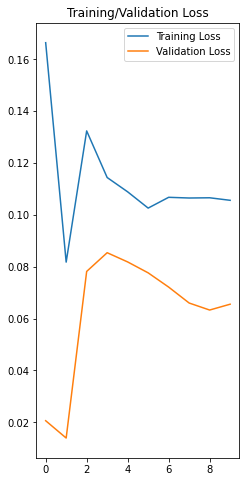

Epoch 1/10
102/102 [==============================] - 1s 9ms/step - loss: 0.0890 - mae: 0.0866 - rmse: 0.0888 - val_loss: 0.0271 - val_mae: 0.0248 - val_rmse: 0.0270
Epoch 2/10
102/102 [==============================] - 1s 8ms/step - loss: 0.1178 - mae: 0.1154 - rmse: 0.1172 - val_loss: 0.0412 - val_mae: 0.0392 - val_rmse: 0.0414
Epoch 3/10
102/102 [==============================] - 1s 8ms/step - loss: 0.0981 - mae: 0.0961 - rmse: 0.0978 - val_loss: 0.0273 - val_mae: 0.0247 - val_rmse: 0.0268
Epoch 4/10
102/102 [==============================] - 1s 9ms/step - loss: 0.0823 - mae: 0.0801 - rmse: 0.0820 - val_loss: 0.0224 - val_mae: 0.0207 - val_rmse: 0.0217
Epoch 5/10
102/102 [==============================] - 1s 8ms/step - loss: 0.0772 - mae: 0.0740 - rmse: 0.0769 - val_loss: 0.0375 - val_mae: 0.0354 - val_rmse: 0.0374

Epoch 00005: val_loss improved from 0.06553 to 0.03752, saving model to my_model_5_0.038.h5
Epoch 6/10
102/102 [==============================] - 1s 8ms/step - loss: 0.0

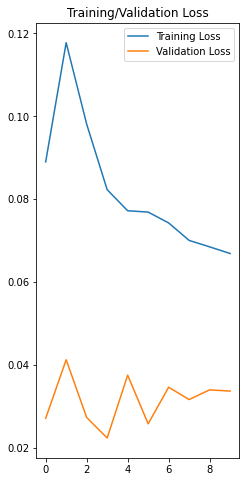

Epoch 1/10
152/152 [==============================] - 3s 7ms/step - loss: 0.0541 - mae: 0.0509 - rmse: 0.0541 - val_loss: 0.0609 - val_mae: 0.0539 - val_rmse: 0.0614
Epoch 2/10
152/152 [==============================] - 1s 7ms/step - loss: 0.0377 - mae: 0.0351 - rmse: 0.0377 - val_loss: 0.0733 - val_mae: 0.0664 - val_rmse: 0.0730
Epoch 3/10
152/152 [==============================] - 1s 7ms/step - loss: 0.0340 - mae: 0.0304 - rmse: 0.0340 - val_loss: 0.0686 - val_mae: 0.0609 - val_rmse: 0.0685
Epoch 4/10
152/152 [==============================] - 1s 7ms/step - loss: 0.0319 - mae: 0.0289 - rmse: 0.0319 - val_loss: 0.0634 - val_mae: 0.0553 - val_rmse: 0.0634
Epoch 5/10
152/152 [==============================] - 1s 7ms/step - loss: 0.0319 - mae: 0.0289 - rmse: 0.0319 - val_loss: 0.0657 - val_mae: 0.0580 - val_rmse: 0.0656

Epoch 00005: val_loss did not improve from 0.03368
Epoch 6/10
152/152 [==============================] - 1s 7ms/step - loss: 0.0358 - mae: 0.0326 - rmse: 0.0358 - val_lo

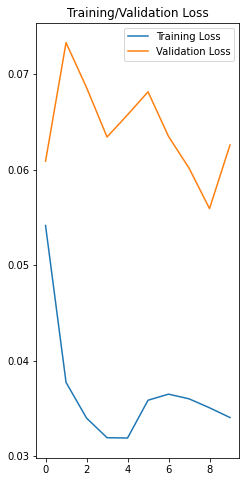

[array([[2509.8472, 2519.6692]], dtype=float32), array([[2519.2393, 2529.9639]], dtype=float32), array([[2531.17  , 2541.9785]], dtype=float32), array([[2543.2441, 2553.5913]], dtype=float32), array([[2554.5024, 2564.26  ]], dtype=float32), array([[2565.1858, 2574.4084]], dtype=float32), array([[2575.739, 2584.51 ]], dtype=float32), array([[2586.0688, 2594.4185]], dtype=float32), array([[2595.7542, 2603.6733]], dtype=float32), array([[2604.827 , 2612.3147]], dtype=float32), array([[2613.2612, 2620.3218]], dtype=float32), array([[2621.0457, 2627.686 ]], dtype=float32), array([[2628.195 , 2634.4285]], dtype=float32), array([[2634.7322, 2640.577 ]], dtype=float32), array([[2640.676, 2646.153]], dtype=float32)]
[2509.8472, 2519.2393, 2531.17, 2543.2441, 2554.5024, 2565.1858, 2575.739, 2586.0688, 2595.7542, 2604.827, 2613.2612, 2621.0457, 2628.195, 2634.7322, 2640.676]


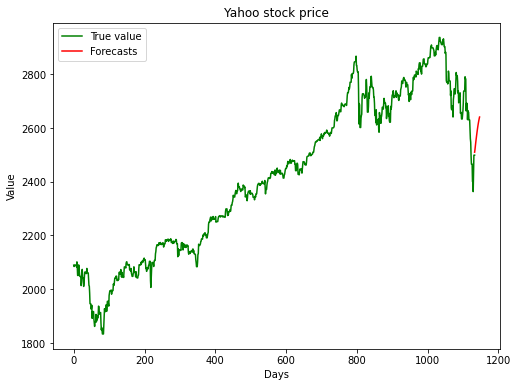

Epoch 1/50
51/51 [==============================] - 4s 25ms/step - loss: 0.3360 - mae: 0.3315 - rmse: 0.3360 - val_loss: 0.0118 - val_mae: 0.0099 - val_rmse: 0.0115
Epoch 2/50
51/51 [==============================] - 0s 9ms/step - loss: 0.1233 - mae: 0.1157 - rmse: 0.1233 - val_loss: 0.0203 - val_mae: 0.0183 - val_rmse: 0.0203
Epoch 3/50
51/51 [==============================] - 0s 9ms/step - loss: 0.1658 - mae: 0.1626 - rmse: 0.1658 - val_loss: 0.0829 - val_mae: 0.0812 - val_rmse: 0.0832
Epoch 4/50
51/51 [==============================] - 0s 9ms/step - loss: 0.1123 - mae: 0.1080 - rmse: 0.1123 - val_loss: 0.0834 - val_mae: 0.0820 - val_rmse: 0.0837
Epoch 5/50
51/51 [==============================] - 0s 9ms/step - loss: 0.1144 - mae: 0.1107 - rmse: 0.1144 - val_loss: 0.0728 - val_mae: 0.0714 - val_rmse: 0.0730

Epoch 00005: val_loss improved from inf to 0.07276, saving model to my_model_5_0.073.h5
Epoch 6/50
51/51 [==============================] - 0s 10ms/step - loss: 0.1217 - mae: 0.1

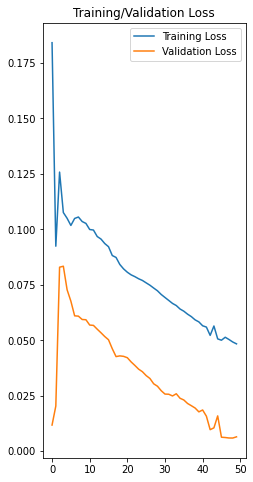

Epoch 1/50
102/102 [==============================] - 1s 9ms/step - loss: 0.0323 - mae: 0.0299 - rmse: 0.0321 - val_loss: 0.0146 - val_mae: 0.0125 - val_rmse: 0.0142
Epoch 2/50
102/102 [==============================] - 1s 9ms/step - loss: 0.0379 - mae: 0.0353 - rmse: 0.0377 - val_loss: 0.0174 - val_mae: 0.0148 - val_rmse: 0.0168
Epoch 3/50
102/102 [==============================] - 1s 9ms/step - loss: 0.0352 - mae: 0.0327 - rmse: 0.0350 - val_loss: 0.0146 - val_mae: 0.0119 - val_rmse: 0.0149
Epoch 4/50
102/102 [==============================] - 1s 9ms/step - loss: 0.0357 - mae: 0.0328 - rmse: 0.0355 - val_loss: 0.0232 - val_mae: 0.0201 - val_rmse: 0.0238
Epoch 5/50
102/102 [==============================] - 1s 9ms/step - loss: 0.0353 - mae: 0.0316 - rmse: 0.0352 - val_loss: 0.0188 - val_mae: 0.0156 - val_rmse: 0.0196

Epoch 00005: val_loss did not improve from 0.00646
Epoch 6/50
102/102 [==============================] - 1s 9ms/step - loss: 0.0328 - mae: 0.0291 - rmse: 0.0326 - val_lo

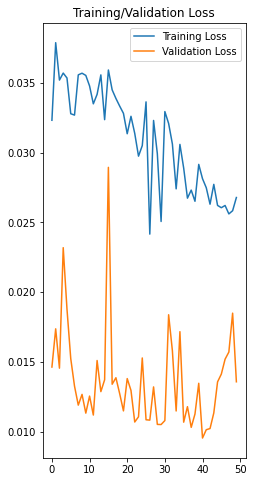

Epoch 1/50
152/152 [==============================] - 3s 8ms/step - loss: 0.0217 - mae: 0.0198 - rmse: 0.0217 - val_loss: 0.0496 - val_mae: 0.0455 - val_rmse: 0.0493
Epoch 2/50
152/152 [==============================] - 1s 7ms/step - loss: 0.0170 - mae: 0.0151 - rmse: 0.0170 - val_loss: 0.0462 - val_mae: 0.0424 - val_rmse: 0.0459
Epoch 3/50
152/152 [==============================] - 1s 7ms/step - loss: 0.0265 - mae: 0.0248 - rmse: 0.0265 - val_loss: 0.0373 - val_mae: 0.0331 - val_rmse: 0.0372
Epoch 4/50
152/152 [==============================] - 1s 7ms/step - loss: 0.0211 - mae: 0.0193 - rmse: 0.0211 - val_loss: 0.0541 - val_mae: 0.0501 - val_rmse: 0.0537
Epoch 5/50
152/152 [==============================] - 1s 7ms/step - loss: 0.0203 - mae: 0.0184 - rmse: 0.0203 - val_loss: 0.0465 - val_mae: 0.0427 - val_rmse: 0.0462

Epoch 00005: val_loss did not improve from 0.00646
Epoch 6/50
152/152 [==============================] - 1s 7ms/step - loss: 0.0177 - mae: 0.0158 - rmse: 0.0177 - val_lo

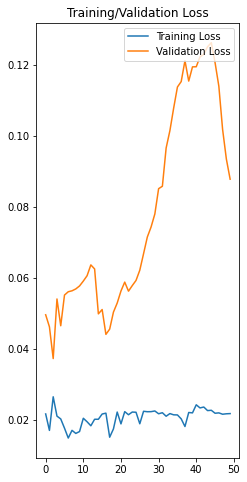

[array([[2488.347 , 2486.2598]], dtype=float32), array([[2495.3  , 2493.228]], dtype=float32), array([[2507.973 , 2505.9302]], dtype=float32), array([[2520.3906, 2518.3926]], dtype=float32), array([[2532.3706, 2530.4392]], dtype=float32), array([[2543.381 , 2541.5247]], dtype=float32), array([[2553.98  , 2552.2007]], dtype=float32), array([[2564.697, 2562.994]], dtype=float32), array([[2575.404 , 2573.7766]], dtype=float32), array([[2586.127 , 2584.5774]], dtype=float32), array([[2596.7366, 2595.269 ]], dtype=float32), array([[2607.0999, 2605.718 ]], dtype=float32), array([[2617.081 , 2615.7876]], dtype=float32), array([[2626.5942, 2625.3918]], dtype=float32), array([[2635.573 , 2634.4624]], dtype=float32)]
[2488.347, 2495.3, 2507.973, 2520.3906, 2532.3706, 2543.381, 2553.98, 2564.697, 2575.404, 2586.127, 2596.7366, 2607.0999, 2617.081, 2626.5942, 2635.573]


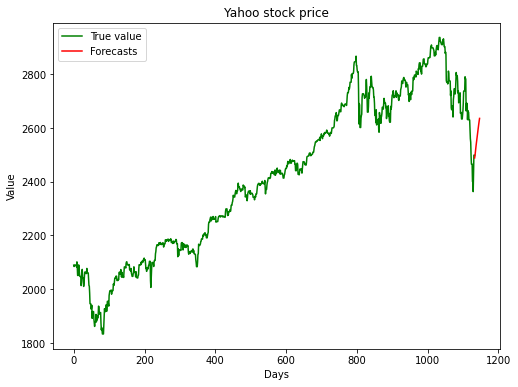

Epoch 1/100
51/51 [==============================] - 4s 26ms/step - loss: 0.2771 - mae: 0.2722 - rmse: 0.2771 - val_loss: 0.0140 - val_mae: 0.0126 - val_rmse: 0.0136
Epoch 2/100
51/51 [==============================] - 0s 10ms/step - loss: 0.0961 - mae: 0.0912 - rmse: 0.0961 - val_loss: 0.0203 - val_mae: 0.0193 - val_rmse: 0.0199
Epoch 3/100
51/51 [==============================] - 0s 10ms/step - loss: 0.1563 - mae: 0.1512 - rmse: 0.1563 - val_loss: 0.0728 - val_mae: 0.0626 - val_rmse: 0.0731
Epoch 4/100
51/51 [==============================] - 1s 10ms/step - loss: 0.1332 - mae: 0.1261 - rmse: 0.1332 - val_loss: 0.0800 - val_mae: 0.0791 - val_rmse: 0.0803
Epoch 5/100
51/51 [==============================] - 1s 10ms/step - loss: 0.1207 - mae: 0.1168 - rmse: 0.1207 - val_loss: 0.0748 - val_mae: 0.0744 - val_rmse: 0.0751

Epoch 00005: val_loss improved from inf to 0.07479, saving model to my_model_5_0.075.h5
Epoch 6/100
51/51 [==============================] - 0s 10ms/step - loss: 0.1227 

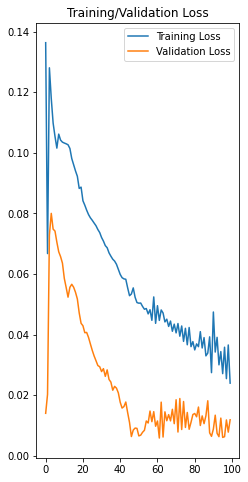

Epoch 1/100
102/102 [==============================] - 1s 10ms/step - loss: 0.0248 - mae: 0.0224 - rmse: 0.0247 - val_loss: 0.0232 - val_mae: 0.0208 - val_rmse: 0.0258
Epoch 2/100
102/102 [==============================] - 1s 10ms/step - loss: 0.0197 - mae: 0.0171 - rmse: 0.0196 - val_loss: 0.0197 - val_mae: 0.0172 - val_rmse: 0.0220
Epoch 3/100
102/102 [==============================] - 1s 9ms/step - loss: 0.0325 - mae: 0.0300 - rmse: 0.0323 - val_loss: 0.0170 - val_mae: 0.0144 - val_rmse: 0.0190
Epoch 4/100
102/102 [==============================] - 1s 10ms/step - loss: 0.0228 - mae: 0.0204 - rmse: 0.0227 - val_loss: 0.0226 - val_mae: 0.0206 - val_rmse: 0.0248
Epoch 5/100
102/102 [==============================] - 1s 9ms/step - loss: 0.0313 - mae: 0.0295 - rmse: 0.0312 - val_loss: 0.0192 - val_mae: 0.0160 - val_rmse: 0.0213

Epoch 00005: val_loss did not improve from 0.00640
Epoch 6/100
102/102 [==============================] - 1s 10ms/step - loss: 0.0312 - mae: 0.0286 - rmse: 0.031

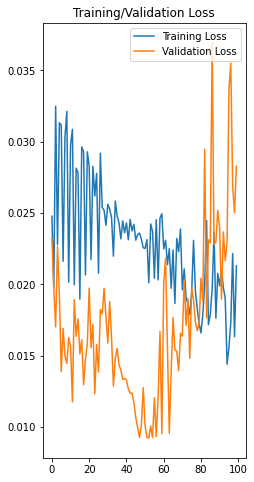

Epoch 1/100
152/152 [==============================] - 3s 8ms/step - loss: 0.0191 - mae: 0.0172 - rmse: 0.0191 - val_loss: 0.0703 - val_mae: 0.0656 - val_rmse: 0.0699
Epoch 2/100
152/152 [==============================] - 1s 8ms/step - loss: 0.0217 - mae: 0.0198 - rmse: 0.0217 - val_loss: 0.0775 - val_mae: 0.0726 - val_rmse: 0.0771
Epoch 3/100
152/152 [==============================] - 1s 8ms/step - loss: 0.0194 - mae: 0.0175 - rmse: 0.0194 - val_loss: 0.0812 - val_mae: 0.0766 - val_rmse: 0.0807
Epoch 4/100
152/152 [==============================] - 1s 8ms/step - loss: 0.0197 - mae: 0.0178 - rmse: 0.0197 - val_loss: 0.0547 - val_mae: 0.0506 - val_rmse: 0.0545
Epoch 5/100
152/152 [==============================] - 1s 8ms/step - loss: 0.0194 - mae: 0.0176 - rmse: 0.0194 - val_loss: 0.0651 - val_mae: 0.0611 - val_rmse: 0.0647

Epoch 00005: val_loss did not improve from 0.00640
Epoch 6/100
152/152 [==============================] - 1s 8ms/step - loss: 0.0179 - mae: 0.0160 - rmse: 0.0179 - 

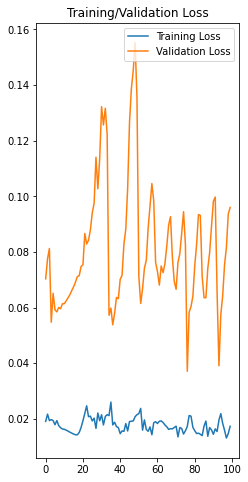

[array([[2492.378, 2493.561]], dtype=float32), array([[2501.1309, 2502.2988]], dtype=float32), array([[2515.3474, 2516.5432]], dtype=float32), array([[2529.4253, 2530.6511]], dtype=float32), array([[2543.2659, 2544.5166]], dtype=float32), array([[2556.5073, 2557.7986]], dtype=float32), array([[2569.7166, 2571.04  ]], dtype=float32), array([[2583.3955, 2584.7498]], dtype=float32), array([[2597.256, 2598.642]], dtype=float32), array([[2611.203 , 2612.6206]], dtype=float32), array([[2625.0713, 2626.5208]], dtype=float32), array([[2638.6387, 2640.1191]], dtype=float32), array([[2651.645 , 2653.1528]], dtype=float32), array([[2663.8071, 2665.3354]], dtype=float32), array([[2674.8335, 2676.3691]], dtype=float32)]
[2492.378, 2501.1309, 2515.3474, 2529.4253, 2543.2659, 2556.5073, 2569.7166, 2583.3955, 2597.256, 2611.203, 2625.0713, 2638.6387, 2651.645, 2663.8071, 2674.8335]


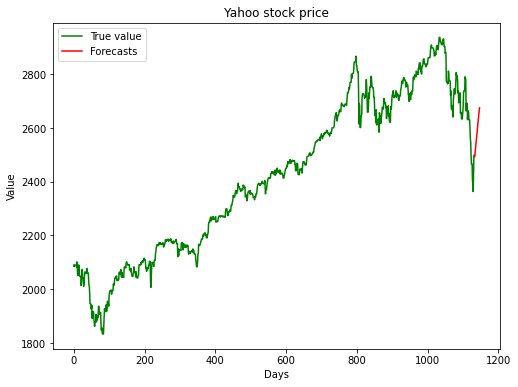

Epoch 1/60
51/51 [==============================] - 5s 28ms/step - loss: 0.2551 - mae: 0.2520 - rmse: 0.2551 - val_loss: 0.0092 - val_mae: 0.0077 - val_rmse: 0.0090
Epoch 2/60
51/51 [==============================] - 1s 10ms/step - loss: 0.1125 - mae: 0.1094 - rmse: 0.1125 - val_loss: 0.0291 - val_mae: 0.0284 - val_rmse: 0.0287
Epoch 3/60
51/51 [==============================] - 1s 11ms/step - loss: 0.1711 - mae: 0.1688 - rmse: 0.1711 - val_loss: 0.0683 - val_mae: 0.0676 - val_rmse: 0.0686
Epoch 4/60
51/51 [==============================] - 1s 11ms/step - loss: 0.1153 - mae: 0.1104 - rmse: 0.1153 - val_loss: 0.0732 - val_mae: 0.0720 - val_rmse: 0.0735
Epoch 5/60
51/51 [==============================] - 1s 11ms/step - loss: 0.1166 - mae: 0.1107 - rmse: 0.1166 - val_loss: 0.0792 - val_mae: 0.0781 - val_rmse: 0.0796

Epoch 00005: val_loss improved from inf to 0.07923, saving model to my_model_5_0.079.h5
Epoch 6/60
51/51 [==============================] - 1s 11ms/step - loss: 0.1153 - mae:

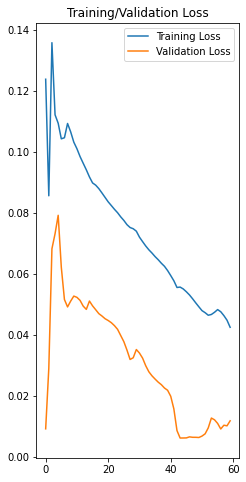

Epoch 1/60
102/102 [==============================] - 1s 11ms/step - loss: 0.0297 - mae: 0.0272 - rmse: 0.0295 - val_loss: 0.0174 - val_mae: 0.0140 - val_rmse: 0.0187
Epoch 2/60
102/102 [==============================] - 1s 10ms/step - loss: 0.0353 - mae: 0.0329 - rmse: 0.0350 - val_loss: 0.0199 - val_mae: 0.0173 - val_rmse: 0.0216
Epoch 3/60
102/102 [==============================] - 1s 11ms/step - loss: 0.0336 - mae: 0.0312 - rmse: 0.0333 - val_loss: 0.0221 - val_mae: 0.0189 - val_rmse: 0.0240
Epoch 4/60
102/102 [==============================] - 1s 11ms/step - loss: 0.0314 - mae: 0.0284 - rmse: 0.0312 - val_loss: 0.0228 - val_mae: 0.0207 - val_rmse: 0.0247
Epoch 5/60
102/102 [==============================] - 1s 10ms/step - loss: 0.0280 - mae: 0.0258 - rmse: 0.0277 - val_loss: 0.0185 - val_mae: 0.0160 - val_rmse: 0.0204

Epoch 00005: val_loss did not improve from 0.00624
Epoch 6/60
102/102 [==============================] - 1s 10ms/step - loss: 0.0330 - mae: 0.0308 - rmse: 0.0327 - 

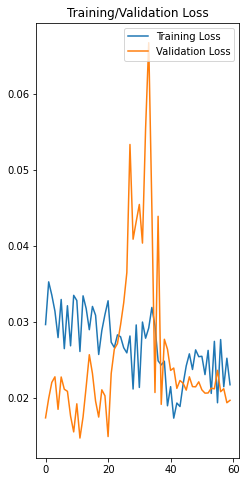

Epoch 1/60
152/152 [==============================] - 2s 11ms/step - loss: 0.0236 - mae: 0.0218 - rmse: 0.0236 - val_loss: 0.0687 - val_mae: 0.0640 - val_rmse: 0.0683
Epoch 2/60
152/152 [==============================] - 2s 11ms/step - loss: 0.0245 - mae: 0.0228 - rmse: 0.0245 - val_loss: 0.0690 - val_mae: 0.0644 - val_rmse: 0.0686
Epoch 3/60
152/152 [==============================] - 2s 10ms/step - loss: 0.0240 - mae: 0.0223 - rmse: 0.0240 - val_loss: 0.0847 - val_mae: 0.0802 - val_rmse: 0.0842
Epoch 4/60
152/152 [==============================] - 2s 11ms/step - loss: 0.0216 - mae: 0.0198 - rmse: 0.0216 - val_loss: 0.0772 - val_mae: 0.0728 - val_rmse: 0.0768
Epoch 5/60
152/152 [==============================] - 2s 10ms/step - loss: 0.0201 - mae: 0.0185 - rmse: 0.0201 - val_loss: 0.0898 - val_mae: 0.0850 - val_rmse: 0.0892

Epoch 00005: val_loss did not improve from 0.00624
Epoch 6/60
152/152 [==============================] - 2s 11ms/step - loss: 0.0205 - mae: 0.0188 - rmse: 0.0205 - 

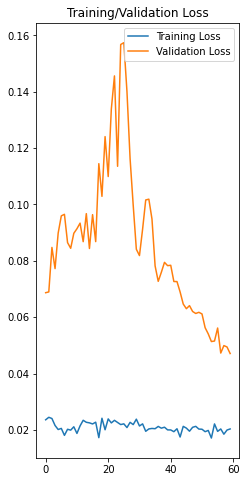

[array([[2492.9963, 2491.9553]], dtype=float32), array([[2501.158, 2500.046]], dtype=float32), array([[2513.2449, 2512.1218]], dtype=float32), array([[2527.2112, 2526.0754]], dtype=float32), array([[2540.1035, 2538.9417]], dtype=float32), array([[2552.4019, 2551.203 ]], dtype=float32), array([[2564.2563, 2563.0217]], dtype=float32), array([[2575.9731, 2574.7092]], dtype=float32), array([[2587.7744, 2586.4849]], dtype=float32), array([[2599.4026, 2598.0913]], dtype=float32), array([[2610.731 , 2609.4011]], dtype=float32), array([[2621.607, 2620.263]], dtype=float32), array([[2631.9265, 2630.5745]], dtype=float32), array([[2641.5784, 2640.2256]], dtype=float32), array([[2650.4668, 2649.1196]], dtype=float32)]
[2492.9963, 2501.158, 2513.2449, 2527.2112, 2540.1035, 2552.4019, 2564.2563, 2575.9731, 2587.7744, 2599.4026, 2610.731, 2621.607, 2631.9265, 2641.5784, 2650.4668]


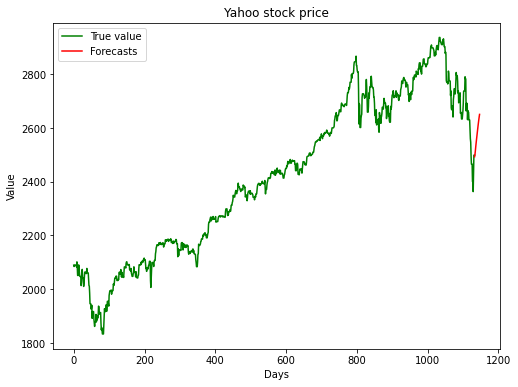

Epoch 1/90
51/51 [==============================] - 5s 28ms/step - loss: 0.2081 - mae: 0.2057 - rmse: 0.2081 - val_loss: 0.0148 - val_mae: 0.0135 - val_rmse: 0.0145
Epoch 2/90
51/51 [==============================] - 1s 12ms/step - loss: 0.0702 - mae: 0.0653 - rmse: 0.0702 - val_loss: 0.0088 - val_mae: 0.0073 - val_rmse: 0.0086
Epoch 3/90
51/51 [==============================] - 1s 11ms/step - loss: 0.1446 - mae: 0.1420 - rmse: 0.1446 - val_loss: 0.0377 - val_mae: 0.0372 - val_rmse: 0.0381
Epoch 4/90
51/51 [==============================] - 1s 12ms/step - loss: 0.1386 - mae: 0.1359 - rmse: 0.1386 - val_loss: 0.0816 - val_mae: 0.0809 - val_rmse: 0.0820
Epoch 5/90
51/51 [==============================] - 1s 12ms/step - loss: 0.1092 - mae: 0.1043 - rmse: 0.1092 - val_loss: 0.0747 - val_mae: 0.0711 - val_rmse: 0.0750

Epoch 00005: val_loss improved from inf to 0.07470, saving model to my_model_5_0.075.h5
Epoch 6/90
51/51 [==============================] - 1s 11ms/step - loss: 0.1142 - mae:

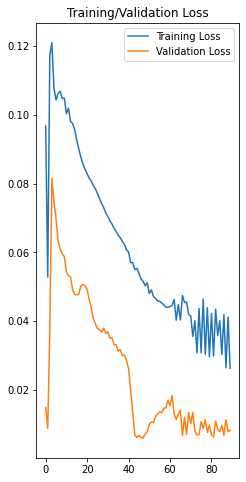

Epoch 1/90
102/102 [==============================] - 1s 12ms/step - loss: 0.0278 - mae: 0.0255 - rmse: 0.0277 - val_loss: 0.0274 - val_mae: 0.0253 - val_rmse: 0.0302
Epoch 2/90
102/102 [==============================] - 1s 11ms/step - loss: 0.0240 - mae: 0.0213 - rmse: 0.0238 - val_loss: 0.0206 - val_mae: 0.0182 - val_rmse: 0.0231
Epoch 3/90
102/102 [==============================] - 1s 11ms/step - loss: 0.0393 - mae: 0.0372 - rmse: 0.0391 - val_loss: 0.0190 - val_mae: 0.0176 - val_rmse: 0.0187
Epoch 4/90
102/102 [==============================] - 1s 11ms/step - loss: 0.0319 - mae: 0.0298 - rmse: 0.0317 - val_loss: 0.0161 - val_mae: 0.0136 - val_rmse: 0.0180
Epoch 5/90
102/102 [==============================] - 1s 11ms/step - loss: 0.0320 - mae: 0.0300 - rmse: 0.0318 - val_loss: 0.0213 - val_mae: 0.0190 - val_rmse: 0.0235

Epoch 00005: val_loss did not improve from 0.00615
Epoch 6/90
102/102 [==============================] - 1s 11ms/step - loss: 0.0224 - mae: 0.0200 - rmse: 0.0222 - 

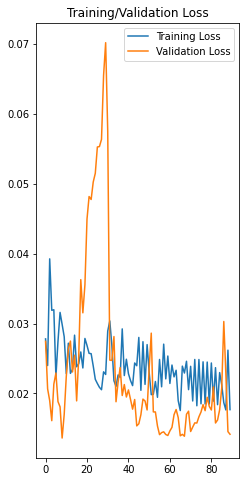

Epoch 1/90
152/152 [==============================] - 2s 11ms/step - loss: 0.0259 - mae: 0.0241 - rmse: 0.0259 - val_loss: 0.0948 - val_mae: 0.0901 - val_rmse: 0.0942
Epoch 2/90
152/152 [==============================] - 2s 11ms/step - loss: 0.0193 - mae: 0.0175 - rmse: 0.0193 - val_loss: 0.0745 - val_mae: 0.0694 - val_rmse: 0.0742
Epoch 3/90
152/152 [==============================] - 2s 11ms/step - loss: 0.0234 - mae: 0.0216 - rmse: 0.0234 - val_loss: 0.0719 - val_mae: 0.0668 - val_rmse: 0.0715
Epoch 4/90
152/152 [==============================] - 2s 11ms/step - loss: 0.0218 - mae: 0.0202 - rmse: 0.0218 - val_loss: 0.0741 - val_mae: 0.0697 - val_rmse: 0.0737
Epoch 5/90
152/152 [==============================] - 2s 11ms/step - loss: 0.0231 - mae: 0.0214 - rmse: 0.0231 - val_loss: 0.0709 - val_mae: 0.0662 - val_rmse: 0.0706

Epoch 00005: val_loss did not improve from 0.00615
Epoch 6/90
152/152 [==============================] - 2s 11ms/step - loss: 0.0223 - mae: 0.0206 - rmse: 0.0223 - 

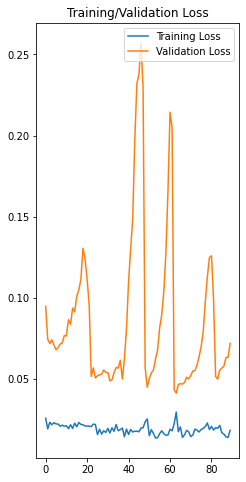

[array([[2479.2322, 2479.5693]], dtype=float32), array([[2482.978, 2483.231]], dtype=float32), array([[2493.3367, 2493.5474]], dtype=float32), array([[2503.7065, 2503.8972]], dtype=float32), array([[2512.4326, 2512.609 ]], dtype=float32), array([[2520.7102, 2520.8748]], dtype=float32), array([[2528.7986, 2528.9412]], dtype=float32), array([[2536.7734, 2536.8887]], dtype=float32), array([[2544.7659, 2544.8513]], dtype=float32), array([[2552.646 , 2552.7034]], dtype=float32), array([[2560.4958, 2560.5278]], dtype=float32), array([[2568.2898, 2568.2983]], dtype=float32), array([[2576.0073, 2575.9946]], dtype=float32), array([[2583.59 , 2583.558]], dtype=float32), array([[2590.9932, 2590.9434]], dtype=float32)]
[2479.2322, 2482.978, 2493.3367, 2503.7065, 2512.4326, 2520.7102, 2528.7986, 2536.7734, 2544.7659, 2552.646, 2560.4958, 2568.2898, 2576.0073, 2583.59, 2590.9932]


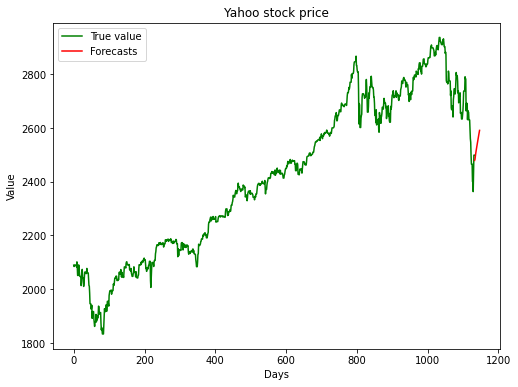

Epoch 1/120
51/51 [==============================] - 5s 29ms/step - loss: 0.3055 - mae: 0.3018 - rmse: 0.3054 - val_loss: 0.0152 - val_mae: 0.0134 - val_rmse: 0.0149
Epoch 2/120
51/51 [==============================] - 1s 12ms/step - loss: 0.1044 - mae: 0.0974 - rmse: 0.1044 - val_loss: 0.0280 - val_mae: 0.0255 - val_rmse: 0.0277
Epoch 3/120
51/51 [==============================] - 1s 11ms/step - loss: 0.1762 - mae: 0.1674 - rmse: 0.1762 - val_loss: 0.0611 - val_mae: 0.0466 - val_rmse: 0.0614
Epoch 4/120
51/51 [==============================] - 1s 12ms/step - loss: 0.1489 - mae: 0.1400 - rmse: 0.1489 - val_loss: 0.0799 - val_mae: 0.0763 - val_rmse: 0.0802
Epoch 5/120
51/51 [==============================] - 1s 12ms/step - loss: 0.1317 - mae: 0.1260 - rmse: 0.1317 - val_loss: 0.0883 - val_mae: 0.0878 - val_rmse: 0.0885

Epoch 00005: val_loss improved from inf to 0.08825, saving model to my_model_5_0.088.h5
Epoch 6/120
51/51 [==============================] - 1s 12ms/step - loss: 0.1226 

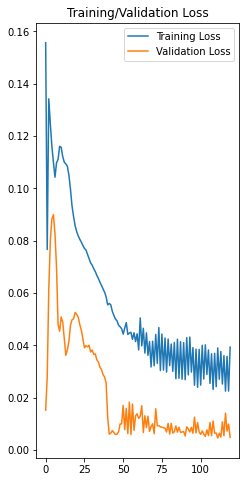

Epoch 1/120
102/102 [==============================] - 1s 12ms/step - loss: 0.0195 - mae: 0.0170 - rmse: 0.0195 - val_loss: 0.0147 - val_mae: 0.0127 - val_rmse: 0.0161
Epoch 2/120
102/102 [==============================] - 1s 11ms/step - loss: 0.0243 - mae: 0.0217 - rmse: 0.0243 - val_loss: 0.0198 - val_mae: 0.0186 - val_rmse: 0.0195
Epoch 3/120
102/102 [==============================] - 1s 11ms/step - loss: 0.0248 - mae: 0.0227 - rmse: 0.0247 - val_loss: 0.0118 - val_mae: 0.0101 - val_rmse: 0.0133
Epoch 4/120
102/102 [==============================] - 1s 11ms/step - loss: 0.0248 - mae: 0.0227 - rmse: 0.0248 - val_loss: 0.0125 - val_mae: 0.0112 - val_rmse: 0.0131
Epoch 5/120
102/102 [==============================] - 1s 11ms/step - loss: 0.0237 - mae: 0.0216 - rmse: 0.0237 - val_loss: 0.0109 - val_mae: 0.0093 - val_rmse: 0.0122

Epoch 00005: val_loss did not improve from 0.00482
Epoch 6/120
102/102 [==============================] - 1s 11ms/step - loss: 0.0239 - mae: 0.0219 - rmse: 0.0

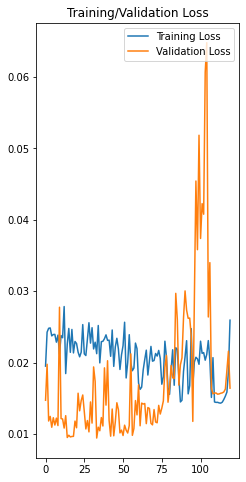

Epoch 1/120
152/152 [==============================] - 2s 11ms/step - loss: 0.0229 - mae: 0.0212 - rmse: 0.0230 - val_loss: 0.0795 - val_mae: 0.0740 - val_rmse: 0.0791
Epoch 2/120
152/152 [==============================] - 2s 11ms/step - loss: 0.0190 - mae: 0.0172 - rmse: 0.0190 - val_loss: 0.0787 - val_mae: 0.0727 - val_rmse: 0.0784
Epoch 3/120
152/152 [==============================] - 2s 11ms/step - loss: 0.0221 - mae: 0.0202 - rmse: 0.0221 - val_loss: 0.0691 - val_mae: 0.0632 - val_rmse: 0.0690
Epoch 4/120
152/152 [==============================] - 2s 11ms/step - loss: 0.0239 - mae: 0.0221 - rmse: 0.0239 - val_loss: 0.0700 - val_mae: 0.0650 - val_rmse: 0.0696
Epoch 5/120
152/152 [==============================] - 2s 11ms/step - loss: 0.0261 - mae: 0.0245 - rmse: 0.0261 - val_loss: 0.0707 - val_mae: 0.0660 - val_rmse: 0.0703

Epoch 00005: val_loss did not improve from 0.00482
Epoch 6/120
152/152 [==============================] - 2s 11ms/step - loss: 0.0221 - mae: 0.0202 - rmse: 0.0

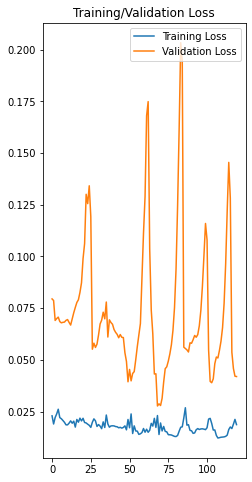

[array([[2468.8064, 2468.7527]], dtype=float32), array([[2466.5393, 2466.3755]], dtype=float32), array([[2472.2842, 2472.0586]], dtype=float32), array([[2479.848, 2479.627]], dtype=float32), array([[2485.748 , 2485.5269]], dtype=float32), array([[2490.5374, 2490.3083]], dtype=float32), array([[2494.1775, 2493.9177]], dtype=float32), array([[2497.56  , 2497.2815]], dtype=float32), array([[2500.797 , 2500.4973]], dtype=float32), array([[2503.967 , 2503.6553]], dtype=float32), array([[2507.166, 2506.847]], dtype=float32), array([[2510.3157, 2509.9912]], dtype=float32), array([[2513.43  , 2513.1013]], dtype=float32), array([[2516.5017, 2516.1704]], dtype=float32), array([[2519.5085, 2519.174 ]], dtype=float32)]
[2468.8064, 2466.5393, 2472.2842, 2479.848, 2485.748, 2490.5374, 2494.1775, 2497.56, 2500.797, 2503.967, 2507.166, 2510.3157, 2513.43, 2516.5017, 2519.5085]


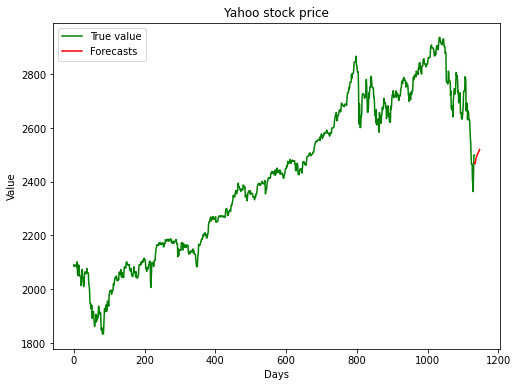

Epoch 1/50
32/32 [==============================] - 5s 41ms/step - loss: 0.3761 - mae: 0.3660 - rmse: 0.3760 - val_loss: 0.0521 - val_mae: 0.0450 - val_rmse: 0.0521
Epoch 2/50
32/32 [==============================] - 0s 15ms/step - loss: 0.1110 - mae: 0.1050 - rmse: 0.1110 - val_loss: 0.0372 - val_mae: 0.0362 - val_rmse: 0.0371
Epoch 3/50
32/32 [==============================] - 1s 15ms/step - loss: 0.1109 - mae: 0.1059 - rmse: 0.1108 - val_loss: 0.0286 - val_mae: 0.0271 - val_rmse: 0.0286
Epoch 4/50
32/32 [==============================] - 1s 16ms/step - loss: 0.1207 - mae: 0.1160 - rmse: 0.1206 - val_loss: 0.0166 - val_mae: 0.0145 - val_rmse: 0.0168
Epoch 5/50
32/32 [==============================] - 0s 15ms/step - loss: 0.1277 - mae: 0.1232 - rmse: 0.1276 - val_loss: 0.0124 - val_mae: 0.0108 - val_rmse: 0.0127

Epoch 00005: val_loss improved from inf to 0.01235, saving model to my_model_5_0.012.h5
Epoch 6/50
32/32 [==============================] - 0s 14ms/step - loss: 0.1335 - mae:

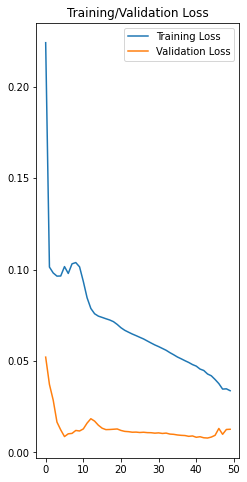

Epoch 1/50
64/64 [==============================] - 2s 27ms/step - loss: 0.0274 - mae: 0.0238 - rmse: 0.0272 - val_loss: 0.0195 - val_mae: 0.0163 - val_rmse: 0.0195
Epoch 2/50
64/64 [==============================] - 1s 13ms/step - loss: 0.0249 - mae: 0.0212 - rmse: 0.0248 - val_loss: 0.0196 - val_mae: 0.0164 - val_rmse: 0.0196
Epoch 3/50
64/64 [==============================] - 1s 14ms/step - loss: 0.0374 - mae: 0.0345 - rmse: 0.0372 - val_loss: 0.0162 - val_mae: 0.0134 - val_rmse: 0.0162
Epoch 4/50
64/64 [==============================] - 1s 15ms/step - loss: 0.0281 - mae: 0.0251 - rmse: 0.0279 - val_loss: 0.0244 - val_mae: 0.0212 - val_rmse: 0.0244
Epoch 5/50
64/64 [==============================] - 1s 14ms/step - loss: 0.0243 - mae: 0.0210 - rmse: 0.0242 - val_loss: 0.0170 - val_mae: 0.0145 - val_rmse: 0.0170

Epoch 00005: val_loss did not improve from 0.00843
Epoch 6/50
64/64 [==============================] - 1s 14ms/step - loss: 0.0306 - mae: 0.0275 - rmse: 0.0304 - val_loss: 0.

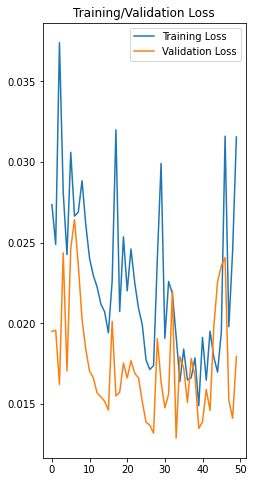

Epoch 1/50
95/95 [==============================] - 1s 14ms/step - loss: 0.0283 - mae: 0.0265 - rmse: 0.0283 - val_loss: 0.0360 - val_mae: 0.0318 - val_rmse: 0.0359
Epoch 2/50
95/95 [==============================] - 1s 13ms/step - loss: 0.0201 - mae: 0.0178 - rmse: 0.0201 - val_loss: 0.0361 - val_mae: 0.0314 - val_rmse: 0.0362
Epoch 3/50
95/95 [==============================] - 1s 13ms/step - loss: 0.0154 - mae: 0.0131 - rmse: 0.0155 - val_loss: 0.0388 - val_mae: 0.0326 - val_rmse: 0.0395
Epoch 4/50
95/95 [==============================] - 1s 13ms/step - loss: 0.0197 - mae: 0.0172 - rmse: 0.0197 - val_loss: 0.0383 - val_mae: 0.0321 - val_rmse: 0.0390
Epoch 5/50
95/95 [==============================] - 1s 13ms/step - loss: 0.0228 - mae: 0.0206 - rmse: 0.0228 - val_loss: 0.0369 - val_mae: 0.0330 - val_rmse: 0.0369

Epoch 00005: val_loss did not improve from 0.00843
Epoch 6/50
95/95 [==============================] - 1s 14ms/step - loss: 0.0159 - mae: 0.0135 - rmse: 0.0159 - val_loss: 0.

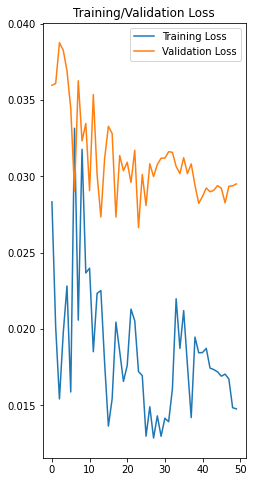

[array([[2497.9463, 2498.121 ]], dtype=float32), array([[2509.9333, 2510.0906]], dtype=float32), array([[2521.492 , 2521.6047]], dtype=float32), array([[2533.8994, 2533.9692]], dtype=float32), array([[2547.2239, 2547.2268]], dtype=float32), array([[2560.3645, 2560.3164]], dtype=float32), array([[2572.9316, 2572.8171]], dtype=float32), array([[2585.3066, 2585.184 ]], dtype=float32), array([[2597.3408, 2597.241 ]], dtype=float32), array([[2609.0405, 2608.9568]], dtype=float32), array([[2620.4534, 2620.3848]], dtype=float32), array([[2631.4048, 2631.353 ]], dtype=float32), array([[2641.8403, 2641.8108]], dtype=float32), array([[2651.6995, 2651.6965]], dtype=float32), array([[2660.9316, 2660.9578]], dtype=float32)]
[2497.9463, 2509.9333, 2521.492, 2533.8994, 2547.2239, 2560.3645, 2572.9316, 2585.3066, 2597.3408, 2609.0405, 2620.4534, 2631.4048, 2641.8403, 2651.6995, 2660.9316]


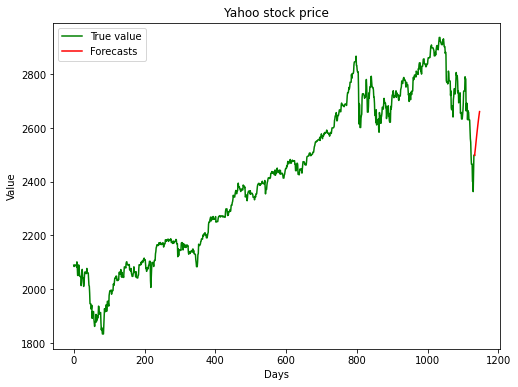

Epoch 1/90
32/32 [==============================] - 5s 43ms/step - loss: 0.3722 - mae: 0.3667 - rmse: 0.3721 - val_loss: 0.0330 - val_mae: 0.0312 - val_rmse: 0.0332
Epoch 2/90
32/32 [==============================] - 0s 14ms/step - loss: 0.1243 - mae: 0.1153 - rmse: 0.1243 - val_loss: 0.0293 - val_mae: 0.0275 - val_rmse: 0.0293
Epoch 3/90
32/32 [==============================] - 0s 15ms/step - loss: 0.1104 - mae: 0.1028 - rmse: 0.1103 - val_loss: 0.0154 - val_mae: 0.0131 - val_rmse: 0.0157
Epoch 4/90
32/32 [==============================] - 0s 15ms/step - loss: 0.1210 - mae: 0.1164 - rmse: 0.1210 - val_loss: 0.0104 - val_mae: 0.0092 - val_rmse: 0.0109
Epoch 5/90
32/32 [==============================] - 1s 17ms/step - loss: 0.1230 - mae: 0.1184 - rmse: 0.1230 - val_loss: 0.0097 - val_mae: 0.0087 - val_rmse: 0.0103

Epoch 00005: val_loss improved from inf to 0.00975, saving model to my_model_5_0.010.h5
Epoch 6/90
32/32 [==============================] - 0s 15ms/step - loss: 0.1233 - mae:

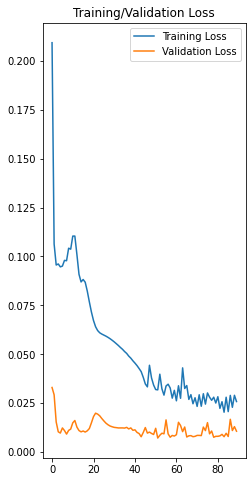

Epoch 1/90
64/64 [==============================] - 2s 27ms/step - loss: 0.0188 - mae: 0.0160 - rmse: 0.0188 - val_loss: 0.0161 - val_mae: 0.0137 - val_rmse: 0.0161
Epoch 2/90
64/64 [==============================] - 1s 13ms/step - loss: 0.0249 - mae: 0.0216 - rmse: 0.0247 - val_loss: 0.0172 - val_mae: 0.0142 - val_rmse: 0.0172
Epoch 3/90
64/64 [==============================] - 1s 13ms/step - loss: 0.0173 - mae: 0.0147 - rmse: 0.0172 - val_loss: 0.0191 - val_mae: 0.0161 - val_rmse: 0.0191
Epoch 4/90
64/64 [==============================] - 1s 13ms/step - loss: 0.0175 - mae: 0.0150 - rmse: 0.0174 - val_loss: 0.0271 - val_mae: 0.0248 - val_rmse: 0.0271
Epoch 5/90
64/64 [==============================] - 1s 14ms/step - loss: 0.0237 - mae: 0.0203 - rmse: 0.0237 - val_loss: 0.0198 - val_mae: 0.0163 - val_rmse: 0.0198

Epoch 00005: val_loss did not improve from 0.00806
Epoch 6/90
64/64 [==============================] - 1s 14ms/step - loss: 0.0250 - mae: 0.0217 - rmse: 0.0248 - val_loss: 0.

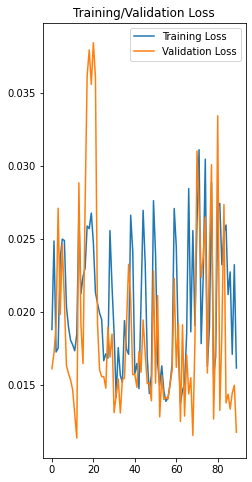

Epoch 1/90
95/95 [==============================] - 1s 15ms/step - loss: 0.0172 - mae: 0.0149 - rmse: 0.0172 - val_loss: 0.0581 - val_mae: 0.0525 - val_rmse: 0.0579
Epoch 2/90
95/95 [==============================] - 1s 14ms/step - loss: 0.0200 - mae: 0.0179 - rmse: 0.0200 - val_loss: 0.0456 - val_mae: 0.0397 - val_rmse: 0.0460
Epoch 3/90
95/95 [==============================] - 1s 14ms/step - loss: 0.0243 - mae: 0.0220 - rmse: 0.0242 - val_loss: 0.0352 - val_mae: 0.0312 - val_rmse: 0.0353
Epoch 4/90
95/95 [==============================] - 1s 14ms/step - loss: 0.0164 - mae: 0.0142 - rmse: 0.0163 - val_loss: 0.0339 - val_mae: 0.0293 - val_rmse: 0.0341
Epoch 5/90
95/95 [==============================] - 1s 14ms/step - loss: 0.0219 - mae: 0.0195 - rmse: 0.0219 - val_loss: 0.0360 - val_mae: 0.0321 - val_rmse: 0.0362

Epoch 00005: val_loss did not improve from 0.00806
Epoch 6/90
95/95 [==============================] - 1s 14ms/step - loss: 0.0155 - mae: 0.0133 - rmse: 0.0155 - val_loss: 0.

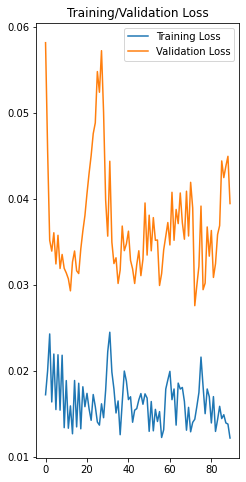

[array([[2504.4873, 2507.1743]], dtype=float32), array([[2518.728 , 2521.4446]], dtype=float32), array([[2532.4844, 2535.1335]], dtype=float32), array([[2547.5913, 2550.141 ]], dtype=float32), array([[2563.445 , 2565.8657]], dtype=float32), array([[2579.1775, 2581.4458]], dtype=float32), array([[2594.2297, 2596.309 ]], dtype=float32), array([[2609.1138, 2611.0105]], dtype=float32), array([[2623.6926, 2625.4048]], dtype=float32), array([[2637.8386, 2639.3599]], dtype=float32), array([[2651.4292, 2652.7656]], dtype=float32), array([[2664.1277, 2665.2812]], dtype=float32), array([[2675.7236, 2676.7   ]], dtype=float32), array([[2686.0347, 2686.842 ]], dtype=float32), array([[2694.922 , 2695.5732]], dtype=float32)]
[2504.4873, 2518.728, 2532.4844, 2547.5913, 2563.445, 2579.1775, 2594.2297, 2609.1138, 2623.6926, 2637.8386, 2651.4292, 2664.1277, 2675.7236, 2686.0347, 2694.922]


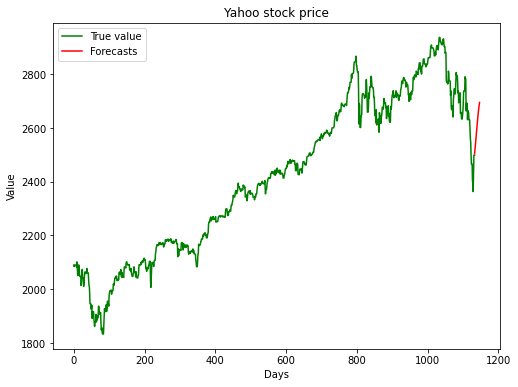

Epoch 1/120
32/32 [==============================] - 4s 41ms/step - loss: 0.3699 - mae: 0.3640 - rmse: 0.3698 - val_loss: 0.0279 - val_mae: 0.0262 - val_rmse: 0.0282
Epoch 2/120
32/32 [==============================] - 1s 15ms/step - loss: 0.1343 - mae: 0.1270 - rmse: 0.1342 - val_loss: 0.0247 - val_mae: 0.0226 - val_rmse: 0.0247
Epoch 3/120
32/32 [==============================] - 0s 15ms/step - loss: 0.1155 - mae: 0.1099 - rmse: 0.1155 - val_loss: 0.0123 - val_mae: 0.0108 - val_rmse: 0.0127
Epoch 4/120
32/32 [==============================] - 1s 17ms/step - loss: 0.1239 - mae: 0.1195 - rmse: 0.1239 - val_loss: 0.0098 - val_mae: 0.0090 - val_rmse: 0.0104
Epoch 5/120
32/32 [==============================] - 0s 15ms/step - loss: 0.1252 - mae: 0.1208 - rmse: 0.1252 - val_loss: 0.0112 - val_mae: 0.0096 - val_rmse: 0.0117

Epoch 00005: val_loss improved from inf to 0.01123, saving model to my_model_5_0.011.h5
Epoch 6/120
32/32 [==============================] - 0s 15ms/step - loss: 0.1254 

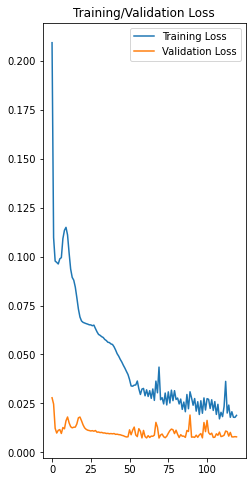

Epoch 1/120
64/64 [==============================] - 2s 27ms/step - loss: 0.0167 - mae: 0.0138 - rmse: 0.0166 - val_loss: 0.0207 - val_mae: 0.0188 - val_rmse: 0.0207
Epoch 2/120
64/64 [==============================] - 1s 15ms/step - loss: 0.0191 - mae: 0.0162 - rmse: 0.0190 - val_loss: 0.0198 - val_mae: 0.0179 - val_rmse: 0.0198
Epoch 3/120
64/64 [==============================] - 1s 14ms/step - loss: 0.0270 - mae: 0.0245 - rmse: 0.0268 - val_loss: 0.0390 - val_mae: 0.0376 - val_rmse: 0.0390
Epoch 4/120
64/64 [==============================] - 1s 14ms/step - loss: 0.0241 - mae: 0.0216 - rmse: 0.0239 - val_loss: 0.0303 - val_mae: 0.0276 - val_rmse: 0.0303
Epoch 5/120
64/64 [==============================] - 1s 14ms/step - loss: 0.0223 - mae: 0.0194 - rmse: 0.0221 - val_loss: 0.0267 - val_mae: 0.0241 - val_rmse: 0.0267

Epoch 00005: val_loss did not improve from 0.00729
Epoch 6/120
64/64 [==============================] - 1s 15ms/step - loss: 0.0259 - mae: 0.0232 - rmse: 0.0257 - val_lo

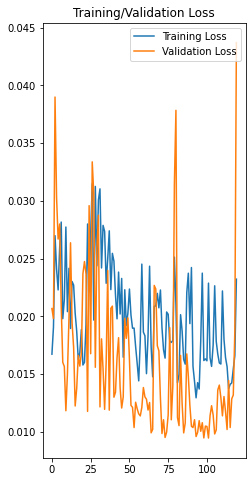

Epoch 1/120
95/95 [==============================] - 1s 14ms/step - loss: 0.0241 - mae: 0.0216 - rmse: 0.0241 - val_loss: 0.0427 - val_mae: 0.0376 - val_rmse: 0.0437
Epoch 2/120
95/95 [==============================] - 1s 14ms/step - loss: 0.0160 - mae: 0.0136 - rmse: 0.0160 - val_loss: 0.0537 - val_mae: 0.0483 - val_rmse: 0.0543
Epoch 3/120
95/95 [==============================] - 1s 14ms/step - loss: 0.0216 - mae: 0.0190 - rmse: 0.0215 - val_loss: 0.0580 - val_mae: 0.0524 - val_rmse: 0.0583
Epoch 4/120
95/95 [==============================] - 1s 14ms/step - loss: 0.0202 - mae: 0.0176 - rmse: 0.0201 - val_loss: 0.0536 - val_mae: 0.0485 - val_rmse: 0.0538
Epoch 5/120
95/95 [==============================] - 1s 14ms/step - loss: 0.0184 - mae: 0.0158 - rmse: 0.0184 - val_loss: 0.0530 - val_mae: 0.0481 - val_rmse: 0.0532

Epoch 00005: val_loss did not improve from 0.00729
Epoch 6/120
95/95 [==============================] - 1s 14ms/step - loss: 0.0154 - mae: 0.0129 - rmse: 0.0154 - val_lo

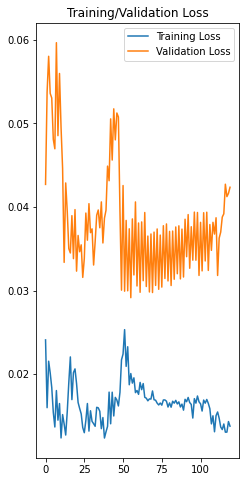

[array([[2489.7068, 2492.7725]], dtype=float32), array([[2498.1628, 2501.0906]], dtype=float32), array([[2509.483 , 2512.3716]], dtype=float32), array([[2522.7212, 2525.6243]], dtype=float32), array([[2535.5696, 2538.452 ]], dtype=float32), array([[2547.624 , 2550.4458]], dtype=float32), array([[2558.9778, 2561.7368]], dtype=float32), array([[2570.5378, 2573.2598]], dtype=float32), array([[2582.28  , 2584.9678]], dtype=float32), array([[2594.1309, 2596.7686]], dtype=float32), array([[2605.949, 2608.521]], dtype=float32), array([[2617.4773, 2619.976 ]], dtype=float32), array([[2628.6272, 2631.0522]], dtype=float32), array([[2639.2578, 2641.6096]], dtype=float32), array([[2649.254 , 2651.5344]], dtype=float32)]
[2489.7068, 2498.1628, 2509.483, 2522.7212, 2535.5696, 2547.624, 2558.9778, 2570.5378, 2582.28, 2594.1309, 2605.949, 2617.4773, 2628.6272, 2639.2578, 2649.254]


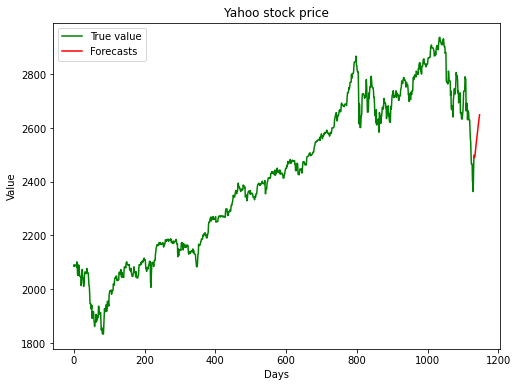

In [18]:
for t in tunning_dict:
  #print(record[r])
  # fitting the model
  timesteps = tunning_dict[t]['timesteps']
  epochs = tunning_dict[t]['epochs']
  batch_size= tunning_dict[t]['batch_size']
  multisteps= tunning_dict[t]['multisteps']
  cv_splits = tunning_dict[t]['cv_splits']
  #print(timesteps,epochs,batch_size,cv_splits)

  X, y = to_supervised(df, timesteps)

  model = build_model(timesteps, n_variate)
  model, history = compile_and_fit(model, epochs, batch_size)
  #print("df: ",df.shape," timesteps",timesteps," multisteps ",multisteps)
  forecasts = forecast(model, df, timesteps, multisteps, scaler)

  print(forecasts)

  prev = []

  #plot do valor previsto da ação de Open
  for f in forecasts:
    prev.append(f[0][0])

  print(prev)
  plot_forecast(df_raw, prev)

  #Scorer
  

  record[t] = history

In [19]:
id_tunning = 1
id_split =1

final_dict = {}

for r in record:
#print(tunning_dict[1]['epochs'])
  loss = []
  mae =[]
  rmse = []
  val_loss = []
  val_mae = []
  val_rmse = []

  for h in record[r]:
    #print("Tunning ID:  ",id_tunning," Split ID: ",id_split)
    #plot_learning_curves(h, tunning_dict[id_tunning]['epochs'])
    #['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse']
    #print("loss: ",sum(h.history['loss'])/len(h.history['loss'])," MAE: ",sum(h.history['mae'])/len(h.history['mae'])," RMSE: ",sum(h.history['rmse'])/len(h.history['rmse'])," VAL_LOSS: ",sum(h.history['val_loss'])/len(h.history['val_loss'])," VAL_MAE: ",sum(h.history['val_mae'])/len(h.history['val_mae'])," VAL_RMSE: ",sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    loss.append(sum(h.history['loss'])/len(h.history['loss']))
    mae.append(sum(h.history['mae'])/len(h.history['mae']))
    rmse.append(sum(h.history['rmse'])/len(h.history['rmse']))
    val_loss.append(sum(h.history['val_loss'])/len(h.history['val_loss']))
    val_mae.append(sum(h.history['val_mae'])/len(h.history['val_mae']))
    val_rmse.append(sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    id_split+=1
  id_split=1
  
  final_dict[id_tunning]=[sum(loss)/len(loss), sum(mae)/len(mae),sum(rmse)/len(rmse),sum(val_loss)/len(val_loss),sum(val_mae)/len(val_mae), sum(val_rmse)/len(val_rmse)]

  id_tunning=id_tunning+1



In [20]:
for f in final_dict:
  print("Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE")
  print("ID tunning: ",f, " Valores: ",final_dict[f],"\n")

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  1  Valores:  [0.07732811321814854, 0.07426746400694052, 0.07716539154450099, 0.05273082256317139, 0.04937463970854878, 0.052681857347488405] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  2  Valores:  [0.04372657176107168, 0.041421650337676204, 0.043635797326763474, 0.04220917784298459, 0.039733354796965915, 0.042227617731938755] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  3  Valores:  [0.033821643438811104, 0.03159193245694041, 0.03375472504956027, 0.04077800490893423, 0.038140432415530084, 0.04087424618968119] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  4  Valores:  [0.04079859992489219, 0.038333371902505554, 0.04068617176057564, 0.04743227747838116, 0.04466886631368349, 0.048178708656794494] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  5  Valores:  [0.034907993201718286, 0.032547718938440086, 0.034828029876505885, 0.045046810938597276, 0.0424

In [21]:
print(final_dict)

{1: [0.07732811321814854, 0.07426746400694052, 0.07716539154450099, 0.05273082256317139, 0.04937463970854878, 0.052681857347488405], 2: [0.04372657176107168, 0.041421650337676204, 0.043635797326763474, 0.04220917784298459, 0.039733354796965915, 0.042227617731938755], 3: [0.033821643438811104, 0.03159193245694041, 0.03375472504956027, 0.04077800490893423, 0.038140432415530084, 0.04087424618968119], 4: [0.04079859992489219, 0.038333371902505554, 0.04068617176057564, 0.04743227747838116, 0.04466886631368349, 0.048178708656794494], 5: [0.034907993201718286, 0.032547718938440086, 0.034828029876505885, 0.045046810938597276, 0.04248313366056041, 0.04546846257936624], 6: [0.031354523015518984, 0.02899467719253153, 0.03126531751412484, 0.037212055150626436, 0.03467441672368699, 0.03758741337159235], 7: [0.03677000395332774, 0.03321776646499833, 0.03664075373361508, 0.020571930557489394, 0.017509961525599162, 0.020937082730233664], 8: [0.02961413353267643, 0.026470412131122972, 0.029513787005648

In [22]:
final_df = pd.DataFrame.from_dict(final_dict, orient='index')
final_df.columns = ['Loss','MAE','RMSE','VAL_LOSS','VAL_MAE','VAL_RMSE']
final_df

,Loss,MAE,RMSE,VAL_LOSS,VAL_MAE,VAL_RMSE
1,0.077328,0.074267,0.077165,0.052731,0.049375,0.052682
2,0.043727,0.041422,0.043636,0.042209,0.039733,0.042228
3,0.033822,0.031592,0.033755,0.040778,0.038140,0.040874
4,0.040799,0.038333,0.040686,0.047432,0.044669,0.048179
5,0.034908,0.032548,0.034828,0.045047,0.042483,0.045468
6,0.031355,0.028995,0.031265,0.037212,0.034674,0.037587
7,0.036770,0.033218,0.036641,0.020572,0.017510,0.020937
8,0.029614,0.026470,0.029514,0.022522,0.019890,0.022785
9,0.027740,0.024702,0.027632,0.021596,0.018974,0.021919


In [23]:
final_df.to_csv(r"resultados.csv",index=True)